In [125]:
import numpy as np
import pandas as pd
import math
import random
import multiprocessing
from datetime import datetime
import sys
# from pyrsistent import freeze, thaw
import networkx as nx
from collections.abc import Iterable
import pickle
import matplotlib
import scipy
import pickle

In [121]:
class MultiPente():
  def __init__(self, n_players=2, n_games=100):
    self.boards = np.zeros(shape=(n_players, 19, 19, n_games))
    self.prev_boards = np.zeros(shape=(n_players, 19, 19, n_games))
    self.pairs = [dict(zip(list(range(0,n_players)), [0]*n_players)) for _ in range(n_games)]

    self.n_players = n_players
    self.n_games = n_games
    self.completed = [False] * n_games
    self.graph = nx.DiGraph()
    self.history = {}
    self.outcomes = {}

  def getLegalMoves(self):
    occupied = np.sum(self.boards, axis=0)
    mask = np.ma.masked_equal(occupied, 0)
    return mask.mask

  def checkRow(self, seq):
    winning_seq = np.array([1, 1, 1, 1, 1])
    if 5 in np.convolve(winning_seq, seq, "valid"):
      return True
    else:
      return False

  def totuple(self, a):
    master = []
    for array in a:
      tup = []
      for sub_array in array:
        sub_tup = tuple(sub_array)
        tup.append(sub_tup)
      tup = tuple(tup)
      master.append(tup)
    master = tuple(master)

    return master

  def getRandomMoveIndices(self):
    mask = self.getLegalMoves()

    all_choices = []

    self.mask = mask

    for game_idx in range(self.n_games):
      choices = np.nonzero(mask[:,:,game_idx])
      choice_list = [tuple(i) for i in zip(list(choices[0]), list(choices[1]), [game_idx] * len(list(choices[0])))]
      choice = random.choice(choice_list)
      
      all_choices.append(choice)

    return np.array(all_choices)

  def makeMoves(self, player_num):

    choices = self.getRandomMoveIndices()

    zeros = np.zeros((choices.shape[0], choices.shape[1] + 1))
    zeros[:, 1:] = choices
    zeros[:, 0] = player_num

    choices = zeros.astype(np.int32)

    for game_num in range(self.n_games):
      if not self.completed[game_num]:
        seen_state=False
        self.last_board = self.boards[:,:,:,game_num].astype('i')

        self.boards[choices[game_num,:][0], choices[game_num,:][1], choices[game_num,:][2], choices[game_num,:][3]] = 1
        self.curr_board = self.boards[:,:,:,game_num].astype('i')
        curr_choice = choices[game_num,:]

        if game_num in self.history.keys():
          self.history[game_num] += [curr_choice.tolist()[0:3]]
        else:
          self.history[game_num] = [curr_choice.tolist()[0:3]]

        x = curr_choice[1]
        y = curr_choice[2]

        padded_board = np.pad(self.curr_board, [(0,0), (4, 4), (4, 4)], mode='constant', constant_values=0)

        relevant = padded_board[player_num, x:x+9, y:y+9]

        diag = np.diagonal(relevant)
        alt_diag = np.fliplr(relevant).diagonal()

        horiz = relevant[4, :]
        vert = relevant[:, 4]

        last_player = 0 if player_num == 1 else 1
        if (self.last_board.tobytes(), self.pairs[game_num][last_player], self.pairs[game_num][player_num]) not in self.graph:
          self.graph.add_node((self.last_board.tobytes(), self.pairs[game_num][last_player], self.pairs[game_num][player_num]), visits=0, outcomes=0)
          seen_state=True

        for i, j in [[0,3], [3,0], [0,-3], [-3,0], [3,3], [-3,3], [3,-3], [-3,-3]]:
          if curr_choice[1] + i in range(0,19) and curr_choice[2] + j in range(0,19):
            if self.curr_board[curr_choice[0], curr_choice[1] + i, curr_choice[2] + j]:
              for player in range(0,self.n_players):
                if player != curr_choice[0]:
                  if self.curr_board[player, curr_choice[1] + i - int(i * 2/3), curr_choice[2] + j - int(j * 2/3)] and self.curr_board[player, curr_choice[1] + i - int(i * 1/3), curr_choice[2] + j - int(j * 1/3)]:
                    self.curr_board[player, curr_choice[1] + i - int(i * 2/3), curr_choice[2] + j - int(j * 2/3)] = 0
                    self.curr_board[player, curr_choice[1] + i - int(i * 1/3), curr_choice[2] + j - int(j * 1/3)] = 0

                    self.pairs[game_num][curr_choice[0]] += 1

        # Add last board state and current board state that stores num visits and sum of game outcomes to graph connected by edge 

        if (self.curr_board.tobytes(), self.pairs[game_num][player_num], self.pairs[game_num][last_player]) not in self.graph:
          self.graph.add_node((self.curr_board.tobytes(), self.pairs[game_num][player_num], self.pairs[game_num][last_player]), visits=0, outcomes=0)
          seen_state=True
        if seen_state:
          self.graph.add_edge((self.last_board.tobytes(), self.pairs[game_num][last_player], self.pairs[game_num][player_num]), 
                              (self.curr_board.tobytes(), self.pairs[game_num][player_num], self.pairs[game_num][last_player]))

        if self.checkRow(diag) or self.checkRow(alt_diag) or self.checkRow(horiz) or self.checkRow(vert):
          # Return 1 if game is completed on move
          self.completed[game_num] = True
          self.outcomes[game_num] = player_num
          # print(player_num)

        if 5 <= max([value for key, value in self.pairs[game_num].items()]):
          # Return 1 if game is completed on move
          self.completed[game_num] = True
          self.outcomes[game_num] = player_num
          # print(player_num)

        if self.completed[game_num] == True:
          self.graph.nodes[(self.curr_board.tobytes(), self.pairs[game_num][player_num], self.pairs[game_num][last_player])]["visits"] += 1
          self.graph.nodes[(self.curr_board.tobytes(), self.pairs[game_num][player_num], self.pairs[game_num][last_player])]["outcomes"] += player_num
          for node in nx.ancestors(self.graph, (self.curr_board.tobytes(), self.pairs[game_num][player_num], self.pairs[game_num][last_player])):
            # print(self.graph)
            if self.graph.nodes[node].get("visits") is None:
              self.graph.nodes[node]["visits"] = 0
            if self.graph.nodes[node].get("outcomes") is None:
              self.graph.nodes[node]["outcomes"] = 0

            self.graph.nodes[node]["visits"] += 1
            self.graph.nodes[node]["outcomes"] += player_num
            # except:
            #   print((self.curr_board.tobytes(), self.pairs[game_num][player_num], self.pairs[game_num][last_player]) in self.graph)
            #   print(self.pairs[game_num])
            #   print(player_num)
            #   print(last_player)
            #   print(self.pairs[game_num][player_num])
            #   print(self.pairs[game_num][last_player])
            #   print(self.graph.nodes[node])
            #   print(self.graph.nodes[node][1])
            #   print(self.graph.nodes[node][2])
            #   sys.exit()
            #   ...

    return self.completed  

  def getBoards(self):
    return self.boards

  def play(self):
    count = 0
    player = -1
    while not np.sum(self.completed) == self.n_games and count < 299:

      if player < self.n_players - 1:
        player+=1
      else:
        player=0

      fin_list = self.makeMoves(player)
      # print("TAKING TURN", count)
      # print(player)
      count += 1

    print("DONE PLAYING", self.n_games, "PENTE GAMES")
    self.reset()

  def reset(self):
    self.boards = np.zeros(shape=(self.n_players, 19, 19, self.n_games))
    self.pairs = [dict(zip(list(range(0, self.n_players)), [0]* self.n_players)) for i in range(self.n_games)]
    self.completed = [False for i in range(self.n_games)]

In [122]:
# multi = MultiPente(n_players = 2, n_games = 1000)
# multi.play()
# print(multi.graph.nodes[multi.curr_board.tobytes()]["visits"])
# print(multi.graph.nodes[multi.curr_board.tobytes()]["outcomes"])

DONE PLAYING 1000 PENTE GAMES


KeyboardInterrupt: 

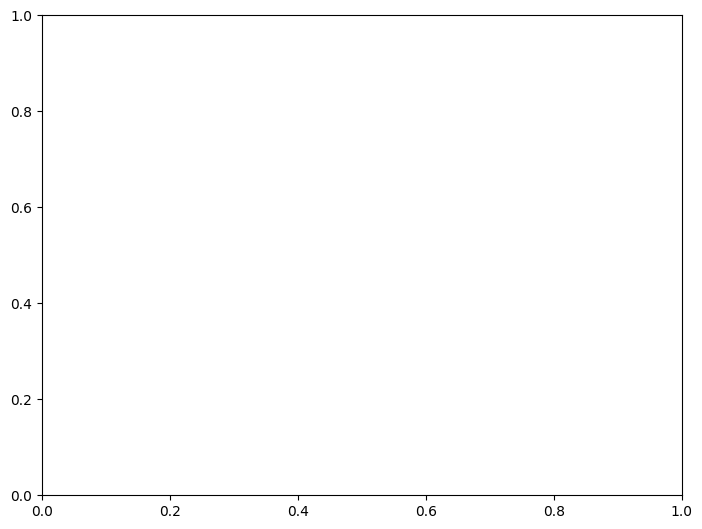

In [123]:
nx.draw(multi.graph)

In [53]:
multi.graph.nodes[multi.curr_board.tobytes()]["outcomes"]

0

In [64]:
num_batches = 100000

for batch in range(num_batches):
  print("BATCH", batch)
  # player_count = random.randint(2,4)
  # print(player_count, "PLAYERS")

  multi = MultiPente(n_players = 2, n_games = 1000)
  multi.play()

  with open(f"games/games_{batch}_2.pkl", "wb") as f:
    pickle.dump({"history": multi.history, "outcomes": multi.outcomes}, f)

BATCH 0
4 PLAYERS
TAKING TURN 0
TAKING TURN 1
TAKING TURN 2
TAKING TURN 3
TAKING TURN 4
TAKING TURN 5
TAKING TURN 6
TAKING TURN 7
TAKING TURN 8
TAKING TURN 9
TAKING TURN 10
TAKING TURN 11
TAKING TURN 12
TAKING TURN 13
TAKING TURN 14
TAKING TURN 15
TAKING TURN 16
TAKING TURN 17
TAKING TURN 18
TAKING TURN 19
TAKING TURN 20
TAKING TURN 21
TAKING TURN 22
TAKING TURN 23
TAKING TURN 24
TAKING TURN 25
TAKING TURN 26
TAKING TURN 27
TAKING TURN 28
TAKING TURN 29
TAKING TURN 30
TAKING TURN 31
TAKING TURN 32
TAKING TURN 33
TAKING TURN 34
TAKING TURN 35
TAKING TURN 36
TAKING TURN 37
TAKING TURN 38
TAKING TURN 39
TAKING TURN 40
TAKING TURN 41
TAKING TURN 42
TAKING TURN 43
TAKING TURN 44
TAKING TURN 45
TAKING TURN 46
TAKING TURN 47
TAKING TURN 48
TAKING TURN 49
TAKING TURN 50
TAKING TURN 51
TAKING TURN 52
TAKING TURN 53
TAKING TURN 54
TAKING TURN 55
TAKING TURN 56
TAKING TURN 57
TAKING TURN 58
TAKING TURN 59
TAKING TURN 60
TAKING TURN 61
TAKING TURN 62
TAKING TURN 63
TAKING TURN 64
TAKING TURN 65
TA

In [5]:
import keras
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import json

from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Add, Embedding, Dropout, Flatten, LocallyConnected1D, Concatenate, Reshape
from keras.models import Model, load_model

In [6]:
embedding_dim = 20
pos_emb_dim = 9
max_players = 4
dictionary_dim = 361
max_input_len = 300
num_heads = 64
ffn_units = 10000
num_samples = 10

player_inp = Input(shape=(max_input_len,))
x_inp = Input(shape=(max_input_len,))
y_inp = Input(shape=(max_input_len,))
turn_inp = Input(shape=(max_input_len,))

player_emb_layer = Embedding(input_dim=max_players, output_dim=2, mask_zero=True)
player_emb = player_emb_layer(player_inp)
x_emb = Embedding(input_dim=dictionary_dim, output_dim=pos_emb_dim)(x_inp)
y_emb = Embedding(input_dim=dictionary_dim, output_dim=pos_emb_dim)(y_inp)

mask = player_emb_layer.compute_mask(player_inp)
mask = mask[:, tf.newaxis, tf.newaxis, :]

### Postional encodings with help from https://machinelearningmastery.com/the-transformer-positional-encoding-layer-in-keras-part-2/
turn_emb = Embedding(input_dim=max_input_len, output_dim=embedding_dim)(turn_inp)
###

concat_emb = Concatenate(axis=-1)([player_emb, x_emb, y_emb])
inp_emb = Add()([concat_emb, turn_emb])

print(type(mask))

att = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim + 2 * pos_emb_dim + 2)(inp_emb, inp_emb, attention_mask=mask)

dropout_1 = Dropout(.1)(att)

# norm_1 = LayerNormalization()(inp_emb + dropout_1)

dense_1 = Dense(units=ffn_units, activation="relu")(dropout_1)

dense_2 = Dense(units=embedding_dim, activation="relu")(dense_1)

dropout_2 = Dropout(.1)(dense_2)

norm_2 = LayerNormalization()(dropout_1 + dropout_2)

norm_5 = LayerNormalization()(norm_2)

dropout_5 = Dropout(0.1)(norm_5)

flat_1 = Flatten()(dropout_5)


dense_5 = Dense(dictionary_dim/2, activation="relu")(flat_1)

out_flat = Dense(dictionary_dim, activation="sigmoid")(dense_5)

out = Reshape((19,19))(out_flat)

model = Model([player_inp, x_inp, y_inp, turn_inp], out)

model.summary()




<class 'keras.engine.keras_tensor.KerasTensor'>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 2)       8           ['input_1[0][0]']                
                                              

In [7]:
def crop(input_list, crop_length, pad_length):
  cropped = input_list[0: crop_length]
  padded = cropped + [0]*(pad_length - len(cropped))
  return padded

player_train = []
x_train = []
y_train = []
turn_train = []

out_train = []

for key in multi.history.keys():
  for sample in range(num_samples):

    rand_num = random.randint(0, len(multi.history[key])-1)
    # print(rand_num)

    player_list = crop([x[0] for x in multi.history[key]], rand_num, max_input_len)

    uncropped_x = [x[1] for x in multi.history[key]]
    uncropped_y = [x[2] for x in multi.history[key]]

    # print(len(uncropped_x))

    x_list = crop(uncropped_x, rand_num, max_input_len)
    y_list = crop(uncropped_y, rand_num, max_input_len)

    turn_list = crop(list(range(max_input_len)), rand_num, max_input_len)

    out_list = np.zeros((19,19))
    out_list[uncropped_x[rand_num], uncropped_y[rand_num]] = multi.outcomes[key]

    player_train.append(player_list)
    x_train.append(x_list)
    y_train.append(y_list)
    turn_train.append(turn_list)
    out_train.append(out_list)

player_train = np.array(player_train)
x_train = np.array(x_train)
y_train = np.array(y_train)
turn_train = np.array(turn_train)
out_train = np.array(out_train)


In [8]:
model.compile(optimizer="adam", loss="binary_crossentropy")


In [9]:
# model.fit([player_train, x_train, y_train, turn_train], out_train, verbose=1, epochs=10)

Epoch 1/10
10/32 [========>.....................] - ETA: 1:47 - loss: 0.4062

KeyboardInterrupt: 

In [10]:
from keras import backend as K
K._get_available_gpus()

[]

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) # list of DeviceAttributes


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9007026659174977322
xla_global_id: -1
]


In [12]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [13]:
from keras import backend
len(backend._get_available_gpus())

0